tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\T1_Machine\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 1: Loss = 743.9325, Accuracy = 0.7036


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 2: Loss = 415.0264, Accuracy = 0.7686


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 3: Loss = 263.7298, Accuracy = 0.7679


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 4: Loss = 157.6347, Accuracy = 0.7757


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 5: Loss = 96.2772, Accuracy = 0.7657


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 6: Loss = 67.0598, Accuracy = 0.7557


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 7: Loss = 49.9896, Accuracy = 0.7693


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 8: Loss = 42.8045, Accuracy = 0.7664


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 9: Loss = 35.0861, Accuracy = 0.7550


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[legal-bert-base-uncased] Epoch 10: Loss = 40.3621, Accuracy = 0.7600


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 1: Loss = 776.9093, Accuracy = 0.6621


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 2: Loss = 507.5665, Accuracy = 0.7029


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 3: Loss = 380.0776, Accuracy = 0.7236


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 4: Loss = 279.1963, Accuracy = 0.7300


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 5: Loss = 197.4217, Accuracy = 0.7229


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 6: Loss = 147.5813, Accuracy = 0.7386


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 7: Loss = 101.4338, Accuracy = 0.7279


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 8: Loss = 78.4755, Accuracy = 0.7243


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 9: Loss = 62.8940, Accuracy = 0.7193


C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[roberta-base] Epoch 10: Loss = 72.9837, Accuracy = 0.7429
[TFIDF+SVM] Accuracy = 0.7464
                      Model  Epoch  Accuracy  Precision    Recall        F1
0   legal-bert-base-uncased      1  0.703571   0.670644  0.703571  0.672736
1   legal-bert-base-uncased      2  0.768571   0.759329  0.768571  0.758872
2   legal-bert-base-uncased      3  0.767857   0.757724  0.767857  0.751321
3   legal-bert-base-uncased      4  0.775714   0.771354  0.775714  0.768151
4   legal-bert-base-uncased      5  0.765714   0.769457  0.765714  0.755250
5   legal-bert-base-uncased      6  0.755714   0.761206  0.755714  0.751825
6   legal-bert-base-uncased      7  0.769286   0.764184  0.769286  0.764762
7   legal-bert-base-uncased      8  0.766429   0.769770  0.766429  0.764140
8   legal-bert-base-uncased      9  0.755000   0.752956  0.755000  0.740618
9   legal-bert-base-uncased     10  0.760000   0.751036  0.760000  0.747301
10             roberta-base      1  0.662143   0.657272  0.662143  0.616421

C:\Users\T1_Machine\anaconda3\envs\xai_classifier\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


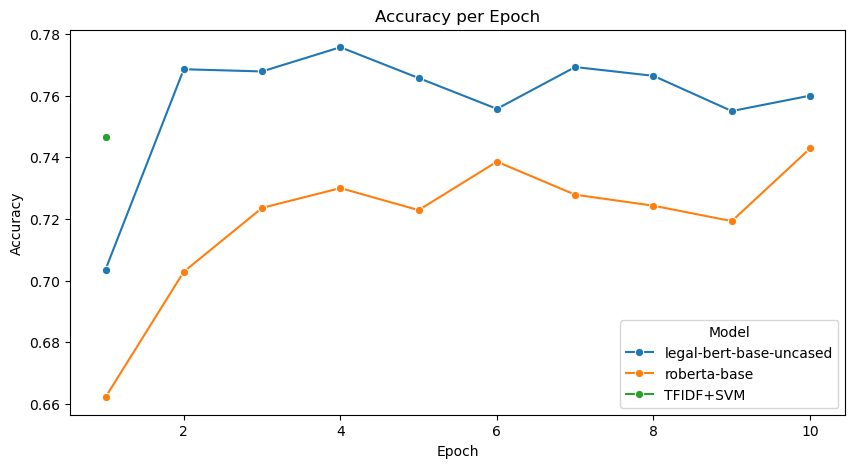

In [1]:
import datasets
# from datasets import DatasetDict
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Load dataset
dataset = datasets.load_dataset("coastalcph/lex_glue", "scotus")

# def sample_subset(dataset_split, sample_ratio=0.1):
#     sample_size = int(len(dataset_split) * sample_ratio)
#     return dataset_split.shuffle(seed=42).select(range(sample_size))

# dataset = DatasetDict({
#     "train": sample_subset(master_dataset["train"]),
#     "test": sample_subset(master_dataset["test"]),
#     "validation": sample_subset(master_dataset["validation"])
# })

# Tokenizer setup
tokenizer_legalbert = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

class TextClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(TextClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

model_legalbert = TextClassifier("nlpaueb/legal-bert-base-uncased", num_labels=13)
model_roberta = TextClassifier("roberta-base", num_labels=13)
metrics_data = []

def train_model(model, tokenizer, dataset, model_name, epochs=10, batch_size=8, lr=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_encodings = tokenizer(dataset["train"]["text"], truncation=True, padding=True, return_tensors="pt")
    val_encodings = tokenizer(dataset["validation"]["text"], truncation=True, padding=True, return_tensors="pt")
    
    train_labels = torch.tensor(dataset["train"]["label"])
    val_labels = torch.tensor(dataset["validation"]["label"])
    
    train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
    val_dataset = torch.utils.data.TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        metrics_data.append({"Model": model_name, "Epoch": epoch+1, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1})
        print(f"[{model_name}] Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {accuracy:.4f}")

train_model(model_legalbert, tokenizer_legalbert, dataset, "legal-bert-base-uncased")
train_model(model_roberta, tokenizer_roberta, dataset, "roberta-base")

def train_tfidf_svm(dataset):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(dataset["train"]["text"])
    X_val_tfidf = vectorizer.transform(dataset["validation"]["text"])
    svm_model = SVC(kernel="linear", probability=True, random_state=42)
    svm_model.fit(X_train_tfidf, dataset["train"]["label"])
    y_pred = svm_model.predict(X_val_tfidf)
    accuracy = accuracy_score(dataset["validation"]["label"], y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(dataset["validation"]["label"], y_pred, average='weighted')
    metrics_data.append({"Model": "TFIDF+SVM", "Epoch": 1, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1})
    print(f"[TFIDF+SVM] Accuracy = {accuracy:.4f}")
    return svm_model, vectorizer

train_tfidf_svm(dataset)
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x="Epoch", y="Accuracy", hue="Model", marker="o")
plt.title("Accuracy per Epoch")
plt.show()